# Model Comparison

This notebook is ported from [this](https://docs.pymc.io/notebooks/model_comparison.html) example notebook from PyMC3.

Model Comparison refers to the task of comparing the predictions of different models that are available to us. It has useful applications. The results obtained after this comparison can be used to select the 'best' model. Alternatively, instead of selecting this 'best' model, we can use Model Averaging to obtain the weighted predictions from the models. These weights can be chosen based on the 'goodness' of each model.

By the 'goodness' of a model, we are referring to how compatible it is to the data. For example, if we have a linear and a quadratic model, we ask the question: Which model best fits the data? Note that here, we cannot use the likelihood to compare the two models. The likelihood simply increases as you increase the complexity of the model. So, we need to find a technique that compares the two models while also accounting for overfitting when using complex models.

We take a simple dataset which is the 8 schools example from Section 5.5 of Gelman et al (2003). This is an attempt to analyse the effect of coaching on the SAT scores of the students. We try two models: Pooled Model and Hierarchical Model. These are explained in some more detail below.

Let's start with the usual routine: import the libraries.

In [1]:
#Import Turing, Distributions and LinearAlgebra 
using Turing, Distributions, LinearAlgebra

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/saumya/.julia/packages/Turing/r03H1/src/Turing.jl:24


# Loading The Data

This data is from 8 schools each of which has about 60 students. In the below block, `y` denotes the estimated treatment effect of coaching and `sigma` denotes the standard deviation in the estimate of this effect. 

In [2]:
J = 8
y = [28,  8, -3,  7, -1,  1, 18, 12]
sigma = [15, 10, 16, 11,  9, 11, 10, 18];

# Pooled Model

We first take a pooled model where `y` is generated from a Gaussian. We already know the standard deviation of this distribution which is the corresponding entry in `sigma`. The mean of the Gaussian is the parameter $\Theta$ that we need to estimate. Note that in this model, we take a single mean $\mu$ for all the schools. The prior on the mean is also taken as a Gaussian. We take an uninformative prior with a high standard deviation, which is close to a uniform distribution. This effectively means that we are taking no assumption on the parametrization. Mathematically, the model is given by:

Likelihood: $ p(y | \Theta) \sim N(\mu, \sigma) $

where $ \Theta = [\mu] $

Prior: $\Theta \sim N(0, 10^6)$

In [3]:
@model pooled_model(y, sigma, J) = begin
    mu ~ Normal(0, 1e6)
    for i = 1:J
        y[i] ~ Normal(mu, sigma[i])
    end
end;

Note how similar the model specifications are in Turing to the actual math. The flexibility provided in Turing makes specifying the model as easy as writing it on a piece of paper!   

## Sampling from the posterior

We use the `NUTS` sampler to sample values from the posterior distribution $p(\Theta | y)$. We also remove the warmup samples by discarding the first 200 values. This number is specified in the second parameter of the `NUTS` sampler.

In [4]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Sample using NUTS.
chain_pooled = sample(pooled_model(y, sigma, J), NUTS(1000, 200, 0.65))

# Remove the warmup samples
chain_pooled = chain_pooled[201:1000, :, :]

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.ForwardDiffAD{40},Union{}}] found initial ϵ: 6.4
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/support/hmc_core.jl:235
┌ Warning: 120.93421495873957 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 172.5055540294431 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 156.60472556096468 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 445.7969834587392 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src

┌ Warning: 3.3024488158392135e15 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 5.943087614347819e15 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 9.831177459559928e15 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 1.306264030952597e16 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 1.2765281930697482e16 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 2.264645788188193e16 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing

┌ Warning: 69138.41638509902 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 68958.34529264437 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 192548.15690342255 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 449848.04027964204 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 815120.8836762024 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 322856.3138316731 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/s

┌ Warning: 3.371283787401361e6 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 8.646202220384471e6 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 1.442584543851149e7 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 3.2588265617361747e7 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 7.970112221771386e7 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 6.866173247295198e7 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Infere

[NUTS] Finished with
  Running time        = 3.801369174999994;
  #lf / sample        = 0.0;
  #evals / sample     = 22.18;
  pre-cond. metric    = [1.0].


Object of type Chains, with data of type 800×7×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 201:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 800
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = mu

parameters
    Mean    SD  Naive SE MCSE    ESS  
mu 8.2399 4.057   0.1434 0.33 151.1804



## Visualising the posterior

The `plot(chain_pooled)` allows us to view the following plots:

- Plot of the sampled values vs the number of iterations. This helps us to visually identify whether the chain has converged.
- Plot of the pdf of the sampled values. These sampled values are an approximation of our model's posterior.

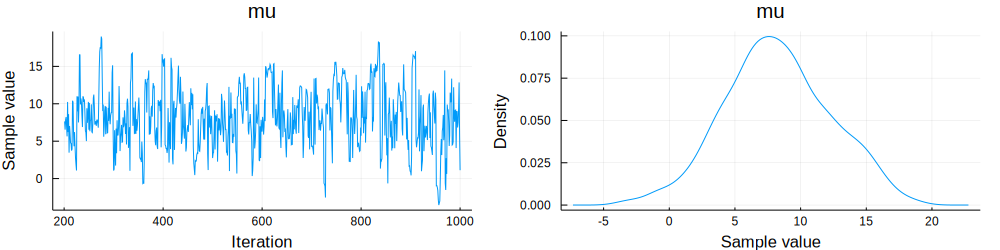

In [5]:
plot(chain_pooled)

# Hierarchical Model

Now, we will construct a hierarchical model. The hierarchical model allows for a random effect that partially pools the data. Each `y[i]` has common parameters $\mu$ and $\tau$. But it also has its own parameter $\eta[i]$. In this way, the groups are similar but also different!

In [6]:
@model hierarchical_model(y, sigma, J) = begin
    eta ~ MvNormal(J, 1)
    mu ~ Normal(0, 1e6)
    tau ~ Gamma(1, 1)
    for i = 1:J
        y[i] ~ Normal(mu + tau*eta[i], sigma[i])
    end
end;

## Sampling from the posterior

In [7]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Sample using NUTS.
chain_hierarchical = sample(hierarchical_model(y, sigma, J), NUTS(1000, 200, 0.65))

# Remove the warmup samples
chain_hierarchical = chain_hierarchical[201:1000, :, :]

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.ForwardDiffAD{40},Union{}}] found initial ϵ: 0.4
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/support/hmc_core.jl:235
┌ Warning: 7.558388434921228 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Warning: 17.614603436454196 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/stepsize.jl:96
┌ Info:  Adapted ϵ = 0.8791097590332617, std = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]; 200 iterations is used for adaption.
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/adapt/adapt.jl:91


[NUTS] Finished with
  Running time        = 2.313346492999996;
  #lf / sample        = 0.0;
  #evals / sample     = 25.665;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,....


Object of type Chains, with data of type 800×16×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 201:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 800
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = eta[5], eta[6], eta[8], eta[3], eta[4], eta[7], tau, eta[1], mu, eta[2]

parameters
         Mean    SD   Naive SE  MCSE     ESS  
eta[1]  0.1210 1.0680   0.0378 0.0536 396.6738
eta[2]  0.0419 1.0806   0.0382 0.0369 800.0000
eta[3] -0.1031 1.0110   0.0357 0.0172 800.0000
eta[4]  0.0283 0.9504   0.0336 0.0293 800.0000
eta[5] -0.0903 1.0239   0.0362 0.0204 800.0000
eta[6]  0.0324 0.9471   0.0335 0.0199 800.0000
eta[7]  0.0499 0.9606   0.0340 0.0331 800.0000
eta[8]  0.0117 0.8965   0.0317 0.0284 800.0000
    mu  7.6013 4.2377   0.1498 0.3018 197.1300
   tau  0.9188 0.9679   0.0342 0.0379 652.7181



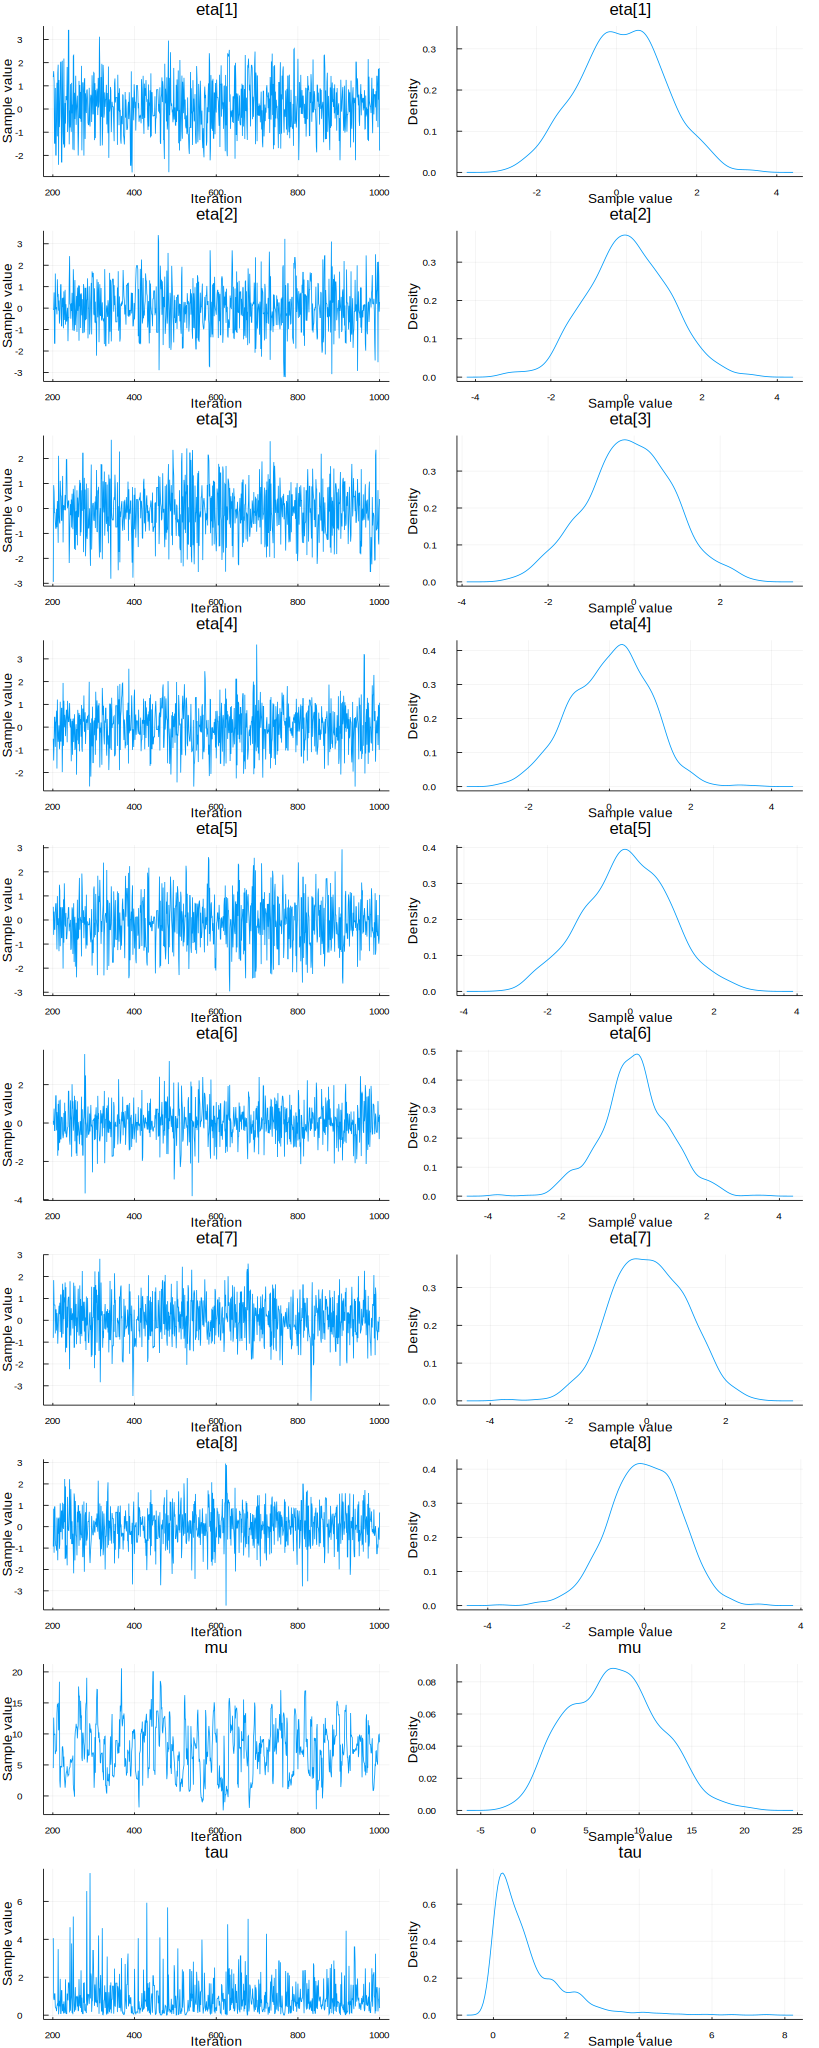

In [8]:
plot(chain_hierarchical)

# Model Comparison with WAIC

The code block below manually calculates the WAIC. This is likely to be temporary until `MCMCChains` supports these functions natively.

The [WAIC Criterion](http://www.jmlr.org/papers/volume11/watanabe10a/watanabe10a.pdf) (Watanabe, Sumio (2010)) is a way to measure the fit of Bayesian models. Lower the WAIC value, the better the fit of the model. This criterion requires the following things:

- The data `y`
- Samples from the posterior distribution
- The likelihood pdf

The equation for WAIC is given by:

$$ WAIC = -2 * (LPPPD - p_{waic})$$

Here, LPPPD is the log pointwise posterior predictive density and $p_{waic}$ is the correction for effective number of parameters to adjust for overfitting. As compared to other Information Criteria, WAIC is more 'Bayesian' as it averages over the posterior distribution rather than using just a point estimate.

Below, we calculate the WAIC values for each of the two models individually.

## Pooled Model

In [9]:
lpppd = 0.0
p_pooled = 0.0

#Looping over all observations
for i = 1:J
    likelihood = Float64[]
    
    # Computing the likelihood for each point in the posterior
    for mu_value in chain_pooled[:mu] 
        dist = Normal(mu_value, sigma[i])
        push!(likelihood, pdf(dist, y[i]) )
    end
    
    # Adding the contribution of the current observation in lpppd
    log_mean = log(mean(likelihood))
    lpppd += log_mean
    
    #Calculating the p_waic value
    log_likelihood = log.(likelihood)
    var_likelihood = var(log_likelihood)
    p_pooled += var_likelihood
end

#Applying the above mentioned equation to get the final WAIC value
waic_pooled = -2*(lpppd - p_pooled);

In [10]:
waic_pooled, p_pooled

(61.09361199100551, 0.6585373593502044)

## Hierarchical Model

In [11]:
sampling_size = 800
lpppd = 0.0
p_hierarchical = 0.0
for i = 1:J
    likelihood = Float64[]
    
    # Computing the likelihood for each point in the posterior
    # Note that here, we have to take the value of eta corresponding to the observation in the outer loop 
    # Looping over all the samples
    for sample = 1:sampling_size
        mu_value = chain_hierarchical[:mu][sample] 
        eta_value = chain_hierarchical[:eta][sample,i,:]
        tau_value = chain_hierarchical[:tau][sample] 
        dist = Normal(mu_value + eta_value[1]*tau_value, sigma[i])
        push!(likelihood, pdf(dist, y[i]) )
    end
    
    # Adding the contribution of the current observation in lpppd
    log_mean = log(mean(likelihood))
    lpppd += log_mean
    
    #Calculating the p_waic value
    log_likelihood = log.(likelihood)
    var_likelihood = var(log_likelihood)
    p_hierarchical += var_likelihood
end

#Applying the above mentioned equation to get the final WAIC value
waic_hierarchical = -2*(lpppd - p_hierarchical);

In [12]:
waic_hierarchical, p_hierarchical

(61.22332940195825, 0.7444504143596025)

# Interpretation

Since the hierarchical model seems to be more complex and flexible, one might expect it to fit better on our data. It does have higher complexity which can be seen by comparing the p_waic values for both the models.

In [13]:
p_pooled, p_hierarchical

(0.6585373593502044, 0.7444504143596025)

So, we get:

`p_hierarchical` > `p_pooled`

However, when it comes to deciding which model better fits the data ('goodness' of the model, as discussed earlier), we can see that the computed `waic` values for the models are approximately equal.

In [14]:
waic_pooled, waic_hierarchical

(61.09361199100551, 61.22332940195825)

This means that both models are equally compatible with our data. Hence, we may be tempted to use the more complex model but this example shows that the simpler pooled model compares equally well.